In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import ipdb
import pickle

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report 

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Reshape, Dropout, Concatenate, BatchNormalization, Activation
from keras.layers import Conv2D, MaxPool2D, Embedding, GlobalMaxPool2D
from keras.models import Model, load_model
from keras import backend as K

Using TensorFlow backend.


Data Cleaning Imports

In [2]:
import re, string, unicodedata
import nltk 
import contractions
import inflect 
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import regex

In [83]:
embedding_dir = '/opt/flask/src/Flask_Core/Nltk/Data/flaskwordembeddings'
max_sequence_length = 30
vocabulary_size = 20000
embedding_dim = 300
clean_data = False
VALIDATION_SPLIT = 0.40

Loading Data

In [80]:
train_df = pd.read_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/Full_data.csv')
#validation_df = pd.read_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/validation_full_training_datathon3_5_70_percent_monday_loop.csv')
#test_df = pd.read_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/thirty_percent_for_testing_data.csv')

In [81]:
print(f'length of training data Before cleaning:{len(train_df)}')
#print(f'length of validation data Before Cleaning:{len(validation_df)}')
#print(f'length of test data Before Cleaning:{len(test_df)}')

length of training data Before cleaning:2872


Data Cleaning

In [6]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

def remove_non_ascii(words):
    """Remove the non ascii characters from list of tokenized words"""
    non_ascii_removed = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        non_ascii_removed.append(new_word)
    return non_ascii_removed

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    lower_cased = []
    for word in words:
        new_word = word.lower()
        lower_cased.append(new_word)
    return lower_cased

def remove_punctuations(words):
    """Remove punctuation from list of tokenized words"""
    punctuation_removed = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            punctuation_removed.append(new_word)
    return punctuation_removed

def replace_number(words):
    """Replace all integer occurances in the list of tokenized words with textual representation"""
    p = inflect.engine()
    number_replaced = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            number_replaced.append(new_word)
        else:
            number_replaced.append(word)
    return number_replaced

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    stopwords_removed = []
    for word in words:
        if word not in stopwords.words('english'):
            stopwords_removed.append(word)
    return stopwords_removed

def lemmatize_words(words):
    """lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def remove_emai_phone(words):
    """remove the email and phone number"""
    email_phone_removed = []
    for word in words:
        #ipdb.set_trace()
        phone_removed = re.sub(r'[a-z0-9\.\-+_]+@[a-z0-9\.\-+_]+\.[a-z]+','',word)
        removed = re.sub(r'\S*7\S*\s?','',phone_removed)
        fax_removal = re.sub(r'\S*fax\S*\s?','',removed)
        cell_removal = re.sub(r'\S*cell\S*\s?','',fax_removal)
        final_remove = re.sub(r'\"intouch\:[0-9a-zA-Z\@\.]{1,}\"','',cell_removal)
        email_phone_removed.append(final_remove)
    return email_phone_removed

def cleaning_text(text):
    tokens = tokenize(text)
    non_ascii_removed = remove_non_ascii(tokens)
    lower_cased_words = to_lowercase(non_ascii_removed)
    remove_punctuation = remove_punctuations(lower_cased_words)
    numbers_replaced = replace_number(remove_punctuation)
    stopwords_removed = remove_stopwords(numbers_replaced)
    lemmatized_words = lemmatize_words(stopwords_removed)
    email_ph_removed = remove_emai_phone(lemmatized_words)
    return email_ph_removed

In [7]:
#training data cleaning
sent = []
for text in train_df['Text']:
    cleaned_text = cleaning_text(text)
    for row in cleaned_text:
        sequ = ''
    for word in cleaned_text:
        #ipdb.set_trace()
        sequ = sequ+' '+word
    sent.append(sequ)

In [8]:
#Creating training dataframe
d = {'Text':sent, 'Label':train_df['Label']}
train = pd.DataFrame(d, index=None)

In [9]:
#validation data cleaning
sent = []
for text in validation_df['Sample']:
    cleaned_text = cleaning_text(text)
    for row in cleaned_text:
        sequ = ''
    for word in cleaned_text:
        #ipdb.set_trace()
        sequ = sequ+' '+word
    sent.append(sequ)

In [10]:
#Creating validation dataframe
d = {'Text':sent, 'Label':validation_df['Label']}
valid = pd.DataFrame(d, index=None)

In [11]:
#testing data cleaning
sent = []
for text in test_df['Sample']:
    cleaned_text = cleaning_text(text)
    for row in cleaned_text:
        sequ = ''
    for word in cleaned_text:
        #ipdb.set_trace()
        sequ = sequ+' '+word
    sent.append(sequ)

In [12]:
#Creating test dataframe
d = {'Text':sent, 'Label':test_df['Label']}
test = pd.DataFrame(d, index=None)

In [13]:
print(f'length of training data Before cleaning:{len(train)}')
print(f'length of validation data Before Cleaning:{len(valid)}')
print(f'length of test data Before Cleaning:{len(test)}')

length of training data Before cleaning:2325
length of validation data Before Cleaning:259
length of test data Before Cleaning:288


In [82]:
le = preprocessing.LabelEncoder()

train_labels = le.fit_transform(train['Label']) if clean_data == True else le.fit_transform(train_df['Label'])

#validation_labels = le.transform(valid['Label']) if clean_data == True else le.transform(validation_df['Label'])

#test_labels = le.transform(test['Label']) if clean_data == True else le.transform(test_df['Label'])

#label_dict = dict(zip(list(le.classes_), le.transform(list(le.classes_))))
print(label_dict)

num_classes = len(le.classes_)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31}


Toeknizing tex and creating word index

In [87]:
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(train['Text']) if clean_data == True else tokenizer.fit_on_texts(train_df['Text'])
#ipdb.set_trace()
train_sequences = tokenizer.texts_to_sequences(train['Text']) if clean_data == True else tokenizer.texts_to_sequences(train_df['Text'])
#validation_sequences = tokenizer.texts_to_sequences(valid['Text']) if clean_data == True else tokenizer.texts_to_sequences(validation_df['Text'])


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

training_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
#valid_data = pad_sequences(validation_sequences, maxlen=max_sequence_length)

training_labels = to_categorical(np.asarray(train_labels))
#valid_labels = to_categorical(np.asarray(validation_labels))

# split the data into a training set and a validation set
indices = np.arange(training_data.shape[0])
np.random.shuffle(indices)
training_data = training_data[indices]
training_labels = training_labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * training_data.shape[0])

training_data = training_data[:-num_validation_samples]
training_labels = training_labels[:-num_validation_samples]
valid_data = training_data[-num_validation_samples:]
valid_labels = training_labels[-num_validation_samples:]

print('Preparing embedding matrix.')


print('Shape of training data tensor:', training_data.shape)
print('Shape of training label tensor:', training_labels.shape)
print('Shape of validation tensor:', valid_data.shape)
print('shape of valid label tensor:',valid_labels.shape )

#print('Preparing embedding matrix.')

Found 2967 unique tokens.
Preparing embedding matrix.
Shape of training data tensor: (1724, 30)
Shape of training label tensor: (1724, 32)
Shape of validation tensor: (1148, 30)
shape of valid label tensor: (1148, 32)


Creating embedding matrix from Word2vec

In [49]:
from gensim.models.keyedvectors import KeyedVectors

In [50]:
embed_model = KeyedVectors.load_word2vec_format('/opt/flask/src/Flask_Core/Nltk/Data/flaskwordembeddings/word2vec.100B.300d.bin', binary=True)

In [51]:
embed_model_txt = embed_model.save_word2vec_format('/opt/flask/src/Flask_Core/Nltk/Data/flaskwordembeddings/word2vec.100B.300d.txt', binary=False)

In [52]:
print('Indexing word vectors.')

embeddings_index = {}
f = open(os.path.join(embedding_dir, 'word2vec.100B.300d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 3000000 word vectors.


In [88]:
num_words = min(vocabulary_size, len(word_index))
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Model

In [89]:
kernel_sizes = [5,5,3]
num_kernels = 512
dropout_rate = 0.5
num_dense_nodes = 100

print("Creating Model...")
inputs = Input(shape=(max_sequence_length,), dtype='int32')
embedding = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix],
                      input_length=max_sequence_length, trainable=False)(inputs)
reshape = Reshape((max_sequence_length,embedding_dim,1))(embedding)

conv_0 = Conv2D(num_kernels, kernel_size=(kernel_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_1 = Conv2D(num_kernels, kernel_size=(kernel_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
conv_2 = Conv2D(num_kernels, kernel_size=(kernel_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)


# maxpool_0 = GlobalMaxPool2D()(conv_0)
# maxpool_1 = GlobalMaxPool2D()(conv_1)
# maxpool_2 = GlobalMaxPool2D()(conv_2)
maxpool_0 = MaxPool2D(pool_size=(max_sequence_length - kernel_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
maxpool_1 = MaxPool2D(pool_size=(max_sequence_length - kernel_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
maxpool_2 = MaxPool2D(pool_size=(max_sequence_length - kernel_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
flatten = Flatten()(concatenated_tensor)
#batch_norm = BatchNormalization()(flatten)
batch_norm_1 = Activation('relu')(flatten)
dropout = Dropout(dropout_rate)(batch_norm_1)
dense = Dense(units=num_dense_nodes, activation=K.tanh)(dropout)
#batch_norm_0 = BatchNormalization()(dense)
batch_norm_0 = Activation('relu')(dense)
dropout = Dropout(dropout_rate)(batch_norm_0)
output = Dense(len(label_dict), activation='softmax')(dropout)

# this creates a model that includes inputs and outputs
model = Model(inputs=inputs, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Creating Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 30, 300)      890400      input_4[0][0]                    
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 30, 300, 1)   0           embedding_4[0][0]                
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 26, 1, 512)   768512      reshape_4[0][0]                  
___________________________________________________________________________________________

In [90]:
model_name = 'test_model_70_40'
saving_path = '/opt/flask/src/Flask_Core/Nltk/Data/TrainedModels/'

In [91]:
history = model.fit(training_data, training_labels, batch_size=32, epochs=50, validation_data=(valid_data, valid_labels))

Train on 1724 samples, validate on 1148 samples
Epoch 1/50
1724/1724 [==============================] - 3s 2ms/step - loss: 3.4952 - acc: 0.0447 - val_loss: 3.3327 - val_acc: 0.1211
Epoch 2/50
1724/1724 [==============================] - 1s 680us/step - loss: 3.3082 - acc: 0.1131 - val_loss: 3.0893 - val_acc: 0.2944
Epoch 3/50
1724/1724 [==============================] - 1s 673us/step - loss: 3.1292 - acc: 0.1839 - val_loss: 2.8519 - val_acc: 0.4138
Epoch 4/50
1724/1724 [==============================] - 1s 682us/step - loss: 2.9399 - acc: 0.2506 - val_loss: 2.5876 - val_acc: 0.5409
Epoch 5/50
1724/1724 [==============================] - 1s 676us/step - loss: 2.6767 - acc: 0.3440 - val_loss: 2.2970 - val_acc: 0.6699
Epoch 6/50
1724/1724 [==============================] - 1s 672us/step - loss: 2.3845 - acc: 0.4339 - val_loss: 1.9215 - val_acc: 0.7805
Epoch 7/50
1724/1724 [==============================] - 1s 674us/step - loss: 2.1023 - acc: 0.5203 - val_loss: 1.5528 - val_acc: 0.8284
Ep

Saving model and Pickling pipeline

In [92]:
model.save(saving_path + model_name + '.h5')

with open(saving_path +'utils_'+ model_name +'.pickle', 'wb') as f:
    pickle.dump((le, tokenizer,num_classes, max_sequence_length), f)

loading model and unpickling

In [93]:
with open (saving_path + 'utils_'+ model_name+'.pickle', 'rb') as f:
    pred_le, pred_tokenizer, pred_num_classes, pred_max_sequence_length = pickle.load(f)

loaded_model = load_model(saving_path + model_name +'.h5')

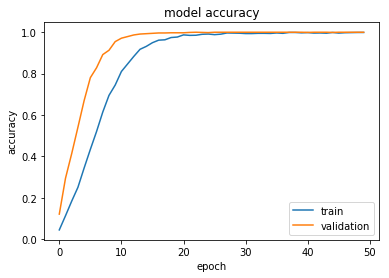

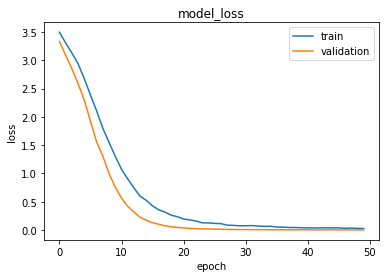

In [94]:
#summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'],loc='lower right')
plt.show()
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Test dataset evaluation and classification report

In [74]:
#processing text to be compatibel with model input
test_sequences = tokenizer.texts_to_sequences(test['Text']) if clean_data == True else tokenizer.texts_to_sequences(test_df['Text'])
test_input = pad_sequences(test_sequences, maxlen = max_sequence_length)

#Get predictions
test_predictions_probs = loaded_model.predict(test_input)
test_predictions = test_predictions_probs.argmax(axis=-1)


test_intent_predictions = le.inverse_transform(test_predictions)
test_intent_original = le.inverse_transform(test_labels)

print(f'accuracy: {sum(test_intent_predictions == test_intent_original)/len(test_labels)}')
print("Precision, Recall and F1-Score:\n\n", classification_report(test_intent_original, test_intent_predictions))

accuracy: 0.5673758865248227
Precision, Recall and F1-Score:

               precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.50      0.40      0.44         5
           2       0.50      0.60      0.55         5
           3       0.67      1.00      0.80         2
           4       0.71      1.00      0.83         5
           5       0.25      0.50      0.33         2
           6       0.75      0.86      0.80         7
           7       1.00      0.60      0.75         5
           8       0.25      0.50      0.33         2
           9       0.00      0.00      0.00         5
          10       0.75      0.75      0.75         4
          11       0.00      0.00      0.00         1
          12       0.54      0.78      0.64         9
          13       0.50      0.25      0.33         4
          14       0.60      0.75      0.67         4
          15       0.33      0.25      0.29         4
          16      

test samples prediction sheet

In [96]:
if if clean_data == True:
    test_df['Predicted_label'] = test_intent_predictions
    prediction_flag = [1 if test_df['Label'][i] == test_df['Predicted_label'][i] else 0 for i in range(len(test_df))]
    test_df['Prediction_flag'] = prediction_flag

    test_df.to_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/'+model_name+'.csv')
else:
    test['Predicted_label'] = test_intent_predictions
    prediction_flag = [1 if test['Label'][i] == test['Predicted_label'][i] else 0 for i in range(len(test))]
    test['Prediction_flag'] = prediction_flag

    test.to_csv('/opt/flask/src/Flask_Core/Nltk/Data/Datasets/'+model_name+'.csv')


confusion matrix

In [97]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots(figsize=(12,12))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [98]:
class_names, class_count = np.unique(test_df['Label'], return_counts=True) if test is None else np.unique(test['Label'], return_counts=True)

Confusion matrix, without normalization


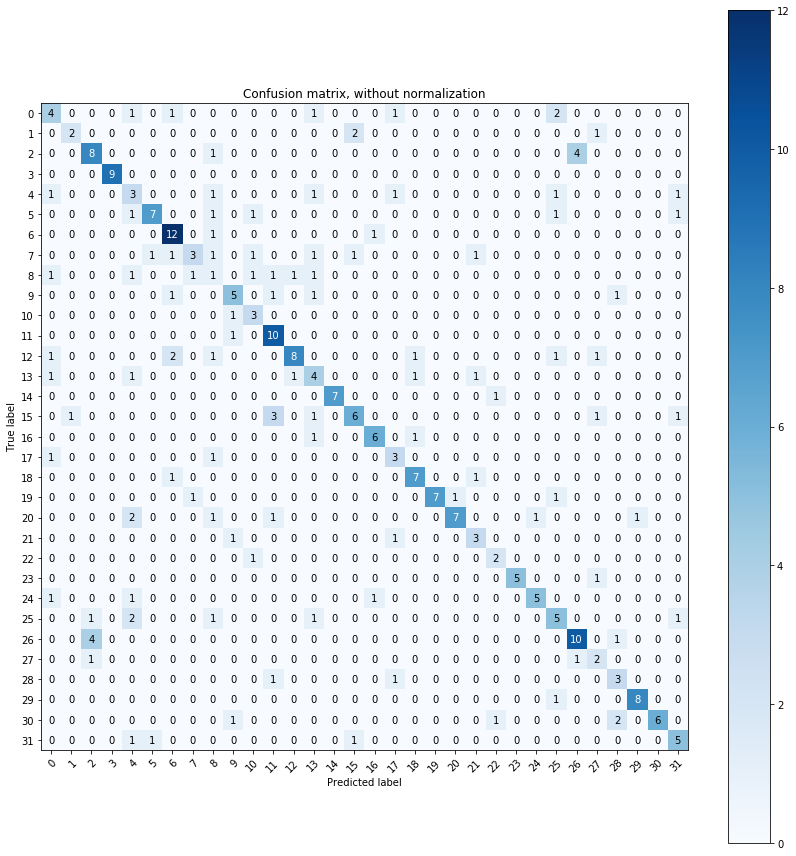

In [99]:
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_intent_original, test_intent_predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
# plot_confusion_matrix(test_intent_original, test_intent_predictions, classes=test_df['String_label'], normalize=True,
#                       title='Normalized confusion matrix')

plt.show()

one sample prediction

In [7]:
def single_prediction(inputs, model, tokenizer, encoder, maxlen):
    pred_text = tokenizer.texts_to_sequences(inputs)
    pred_text = pad_sequences(pred_text, maxlen)
    
    probability = model.predict(pred_text)
    predictions_prob = np.round(probability, 4)
    
    probability = [v for v in predictions_prob]
    
    #ipdb.set_trace()
    all_ids = list(range(0, len(encoder.classes_)))
    return all_ids, probability 

In [9]:
print('Prediciton for Cleaned Text')
#cleaning one text for prediction
text = "Are hoverboard available in Africa?"
cleaned_text = cleaning_text(text)

sent = []
for row in cleaned_text:
    sequ = ''
for word in cleaned_text:
    #ipdb.set_trace()
    sequ = sequ+' '+word
sent.append(sequ)

predicted_label, predict_proba = single_prediction(sent, loaded_model, pred_tokenizer, le, pred_max_sequence_length)

print(f'Predicted probabilities in percentage:\n{predict_proba}\n Predicted labels:\n {predicted_label}')

#Sorting Probablity for prediction
predicted_probablity = predict_proba[0].tolist()

prediction_df = {'Predicted_label':predicted_label, 'predicted_probablity':predicted_probablity}

predictions = pd.DataFrame(data=prediction_df, index = None)
index_dropped = predictions.set_index('Predicted_label')
index_dropped.sort_values(by=['predicted_probablity'], ascending=False)

Prediciton for Cleaned Text


NameError: name 'cleaning_text' is not defined

In [116]:
print('Prediction for uncleaned text')
#uncleaned prediction for single text
predicted_label, predict_proba = single_prediction(["15 kmph? What a joke. My grandfather moves faster."], loaded_model, pred_tokenizer, pred_le, pred_max_sequence_length)

print(f'Predicted probabilities in percentage:\n{predict_proba}\n Predicted labels:\n {predicted_label}')

#Sorting Probablity for prediction
predicted_probablity = predict_proba[0].tolist()

prediction_df = {'Predicted_label':predicted_label, 'predicted_probablity':predicted_probablity}

predictions = pd.DataFrame(data=prediction_df, index = None)
index_dropped = predictions.set_index('Predicted_label')
index_dropped.sort_values(by=['predicted_probablity'], ascending=False)

Prediction for uncleaned text
Predicted probabilities in percentage:
[array([1.813e-01, 6.000e-04, 1.110e-02, 1.000e-04, 1.164e-01, 2.100e-03,
       8.700e-03, 1.600e-03, 5.400e-03, 1.200e-03, 2.000e-03, 2.200e-03,
       1.600e-03, 9.000e-03, 1.520e-02, 2.000e-03, 2.000e-04, 3.410e-02,
       1.000e-04, 1.770e-02, 4.300e-03, 1.200e-03, 2.340e-02, 2.300e-03,
       3.500e-03, 4.848e-01, 4.490e-02, 1.800e-03, 3.100e-03, 1.240e-02,
       4.600e-03, 6.000e-04], dtype=float32)]
 Predicted labels:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


,predicted_probablity
Predicted_label,
25,0.4848
0,0.1813
4,0.1164
26,0.0449
17,0.0341
22,0.0234
19,0.0177
14,0.0152
29,0.0124
